In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from catboost import CatBoostRegressor

## Предобработка файлов

In [2]:
df = pd.read_excel('datamon.xlsx')
df['Дата поставки'] = pd.to_datetime(df['Дата поставки'])
df['Дата заказа'] = pd.to_datetime(df['Дата заказа'])
print(df.shape)
top = pd.read_excel('toplist.xlsx')
print(top.shape)

(4015, 11)
(21, 1)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 11 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   Наименование                                            4015 non-null   object        
 1   Дата поставки                                           4005 non-null   datetime64[ns]
 2   Дата заказа                                             2939 non-null   datetime64[ns]
 3   Срок поставки                                           2939 non-null   float64       
 4   Плановый срок поставки                                  3994 non-null   float64       
 5   Регион                                                  4015 non-null   object        
 6   Объем заказа                                            4015 non-null   int64         
 7   Цена, руб                                               4015

In [4]:
df= df[df['Дата поставки'].notna()]

В данных есть записи без Даты заказа и срока поставки. Заполняем пропуске в сроке поставке медианным значением времени доставки по данному наименованию товара. Затем высчитываем дату заявки.

In [5]:
df["Срок поставки"] = df["Срок поставки"].fillna(df.groupby("Наименование")["Срок поставки"].transform('median'))
df['Дата заказа']=df['Дата заказа'].fillna(df['Дата поставки'] - pd.to_timedelta(df['Срок поставки'], unit='d') )
df = df.sort_values('Дата заказа')

В данных есть 'задвоенные заказы', удалим их что бы не было лика.

In [6]:
print(df.shape)
df= df[df['Дата поставки'].notna()]
df = df.drop_duplicates(subset = ['Наименование','Дата поставки', 'Цена, руб']).drop_duplicates(subset = ['Наименование','Дата заказа', 'Цена, руб'])
df = df[df['Дата заказа'].notna()]
print(df.shape)

(4005, 11)
(3164, 11)


### Выбор методики. 


Категории товаров сильно разнятся по времени. Мы будем строить отдельную модель для каждой категории товаров, используя для обучения 2/3 семплов товаров с более ранней датой заказа и 1/3 последних закзов для тестирования моделей.

Проведем анализ товаров.
Посмотрим медианную и плановое время доставки товаров,количество записей, среднюю стоимость стандартное отклонение абсолютное и его долю от среднего, количество семплов для обучения по выбранной нами методике.

In [7]:

for i in top['товары'].unique():
    top.loc[top['товары']==i,'median_delviery_time'] = df[df['Наименование']==i]['Срок поставки'].median()
    top.loc[top['товары']==i,'plan_delivery_time'] = df[df['Наименование']==i]['Плановый срок поставки'].max()
    top.loc[top['товары']==i,'n_rows'] = df['Наименование'].value_counts()[i]
    top.loc[top['товары']==i,'mean_cost'] = df[df['Наименование']==i]['Цена, руб'].mean()
    top.loc[top['товары']==i,'std_cost'] = df[df['Наименование']==i]['Цена, руб'].std() 
    
    
top['train_sample'] = top['n_rows']//4 * 3
top['precentege_std'] = top['std_cost']/top['mean_cost']
top

,товары,median_delviery_time,plan_delivery_time,n_rows,mean_cost,std_cost,train_sample,precentege_std
0,Зуб 1085.52.05-1,69.0,75.0,73.0,9134.237239,602.284793,54.0,0.065937
1,Колесо 3519.05.02.006,139.0,220.0,54.0,365130.478887,109083.122734,39.0,0.298751
2,Вал 3536.11.01.002,124.0,280.0,32.0,233428.542994,53077.194660,24.0,0.227381
3,Вал 3519.05.02.083,205.0,330.0,26.0,265467.246448,33446.110431,18.0,0.125990
4,Ось 3519.21.00.025,107.0,180.0,22.0,18491.603937,8438.317460,15.0,0.456332
5,Коромысло 3519.21.00.023,108.0,220.0,18.0,167182.014154,27669.278965,12.0,0.165504
6,Вал 3572.05.10.200,224.0,220.0,17.0,254809.741476,13064.105603,12.0,0.051270
7,Вант стрелы 00.1606.49.1,72.0,70.0,24.0,388241.454352,64302.142058,18.0,0.165624
8,Засов 3532.01.02.007,47.0,60.0,24.0,13896.199310,1993.187524,18.0,0.143434
9,Вал 3572.05.10.150,106.5,220.0,22.0,211202.652866,46355.784495,15.0,0.219485


Мы видим что цена некоторых товаров почти не меняется, а некоторых меняется существенно.

### Выбор метрики

Мы будем использывать метрику MAPE (mean absolute percentage error)  по каждой из категории топ товаров. Общей метрикой модели у нас будет среднее MAPE по каждому из топ товаров.

In [8]:
#метрика MAPE процентная ошибка
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Модель на стоимости предыдущей покупки

В качестве базовой модели будем брать для каждого тестового тестовго семпла стоимость равной стоимости предыдущего заказа данного товара.

In [9]:
for name in top['товары'].unique():
    errors = []
    t = df[df['Наименование']==name].reset_index(drop=True)
    
    for i in range((len(t)//4)*3, len(t)):
        errors.append(mean_absolute_percentage_error(t.iloc[i]['Цена, руб'], t.iloc[i-1]['Цена, руб']) )
    top.loc[top['товары']==name,'baseline_mean_mape'] = np.mean(errors)
    top.loc[top['товары']==name,'baseline_std_mape'] = np.std(errors)
    

In [10]:
print('Средняя ошибка в процентах',top['baseline_mean_mape'].mean(),'Со стандатрным отклоением',top['baseline_std_mape'].mean())
top

Средняя ошибка в процентах 9.447211494616504 Со стандатрным отклоением 11.618967153501755


,товары,median_delviery_time,plan_delivery_time,n_rows,mean_cost,std_cost,train_sample,precentege_std,baseline_mean_mape,baseline_std_mape
0,Зуб 1085.52.05-1,69.0,75.0,73.0,9134.237239,602.284793,54.0,0.065937,0.000000,0.000000
1,Колесо 3519.05.02.006,139.0,220.0,54.0,365130.478887,109083.122734,39.0,0.298751,12.640331,14.447244
2,Вал 3536.11.01.002,124.0,280.0,32.0,233428.542994,53077.194660,24.0,0.227381,24.954722,14.950492
3,Вал 3519.05.02.083,205.0,330.0,26.0,265467.246448,33446.110431,18.0,0.125990,3.562355,3.917742
4,Ось 3519.21.00.025,107.0,180.0,22.0,18491.603937,8438.317460,15.0,0.456332,38.293052,55.099867
5,Коромысло 3519.21.00.023,108.0,220.0,18.0,167182.014154,27669.278965,12.0,0.165504,16.050988,14.419305
6,Вал 3572.05.10.200,224.0,220.0,17.0,254809.741476,13064.105603,12.0,0.051270,4.612192,6.043061
7,Вант стрелы 00.1606.49.1,72.0,70.0,24.0,388241.454352,64302.142058,18.0,0.165624,14.004953,17.348959
8,Засов 3532.01.02.007,47.0,60.0,24.0,13896.199310,1993.187524,18.0,0.143434,9.918709,10.015745
9,Вал 3572.05.10.150,106.5,220.0,22.0,211202.652866,46355.784495,15.0,0.219485,3.884510,6.045484


In [11]:
top.corr()['baseline_mean_mape']

median_delviery_time   -0.147241
plan_delivery_time      0.126218
n_rows                  0.012005
mean_cost              -0.202036
std_cost               -0.142318
train_sample            0.016938
precentege_std          0.373029
baseline_mean_mape      1.000000
baseline_std_mape       0.912379
Name: baseline_mean_mape, dtype: float64

Мы видим, что некоторые товары обладающие малоизменчивой стоимостью достаточно точно предсказываются таким базовым способом. Вместе с тем есть товары в которых средняя ошибка более 20%

## Линейная модель

Попробуем использывать линейную модель. Мы закодируем категориальные признаки и создаим признак по дате. В остальном не будем создавать новых признаков.
Наша линейная регрессия обучается на всей тренировочной выборке (2/3) затем предсказывает следующий заказ, мы фиксируем его ошибку. Затем обучаемся снова уже включая этот заказ и предсказываем следущий и так до конца выборки.
(Такой подход нужен для наиболее точного замера ошибки. В проде достаточно будет одной модели на каждую категорию которую будем переобучать раз в опредленный преиод.)

In [12]:
df['date'] = (pd.to_datetime(df['Дата заказа']) - pd.to_datetime('2015-06-09')).dt.days
cat_features = ['Регион', 'Условия платежа', 'НРП - нерегламентная потребность (внеплановая закупка)', 'Поставщик' ]
num_features = ['Плановый срок поставки', 'Объем заказа','date']
encoded_features = pd.get_dummies(df[cat_features],dummy_na=True, drop_first = True)
df_for_lr = df.drop(cat_features,axis=1)
df_for_lr = df_for_lr.join(encoded_features, how='left')


In [13]:
for name in top['товары'].unique():
    errors = []
    t = df_for_lr[df_for_lr['Наименование']==name].drop_duplicates('Дата поставки').drop_duplicates('Дата заказа').reset_index(drop=True)
    t= t.fillna(t.median(numeric_only=True))
    t= t.fillna(0)
    for i in range((len(t)//4 * 3), len(t)):
        train = t.iloc[:i][list(encoded_features.columns)+num_features+['Цена, руб']]
        if len(train)== 1:
            lr = LinearRegression().fit(np.array(train.drop('Цена, руб',axis=1)).reshape(1, -1), train['Цена, руб'])
        else:
            lr = LinearRegression().fit(np.array(train.drop('Цена, руб',axis=1)), train['Цена, руб'])
            
    
        prediction = lr.predict(np.array(t.iloc[i][list(encoded_features.columns)+num_features]).reshape(1, -1))

        errors.append(mean_absolute_percentage_error(t.iloc[i]['Цена, руб'], prediction) )
    top.loc[top['товары']==name,'linear_mean_mape'] =round( np.mean(errors) , 4)
    top.loc[top['товары']==name,'linear_std_mape'] = round( np.std(errors), 4)
    

In [14]:
print('Средняя ошибка в процентах',top['linear_mean_mape'].mean(),'С средним стандатрным отклоением',top['linear_std_mape'].mean())
top

Средняя ошибка в процентах 29.594757142857144 С средним стандатрным отклоением 41.649457142857145


,товары,median_delviery_time,plan_delivery_time,n_rows,mean_cost,std_cost,train_sample,precentege_std,baseline_mean_mape,baseline_std_mape,linear_mean_mape,linear_std_mape
0,Зуб 1085.52.05-1,69.0,75.0,73.0,9134.237239,602.284793,54.0,0.065937,0.000000,0.000000,0.0327,0.0210
1,Колесо 3519.05.02.006,139.0,220.0,54.0,365130.478887,109083.122734,39.0,0.298751,12.640331,14.447244,143.8520,360.9490
2,Вал 3536.11.01.002,124.0,280.0,32.0,233428.542994,53077.194660,24.0,0.227381,24.954722,14.950492,14.6251,13.9510
3,Вал 3519.05.02.083,205.0,330.0,26.0,265467.246448,33446.110431,18.0,0.125990,3.562355,3.917742,7.3704,4.6415
4,Ось 3519.21.00.025,107.0,180.0,22.0,18491.603937,8438.317460,15.0,0.456332,38.293052,55.099867,51.4163,49.1862
5,Коромысло 3519.21.00.023,108.0,220.0,18.0,167182.014154,27669.278965,12.0,0.165504,16.050988,14.419305,31.0658,54.4411
6,Вал 3572.05.10.200,224.0,220.0,17.0,254809.741476,13064.105603,12.0,0.051270,4.612192,6.043061,4.0499,6.5345
7,Вант стрелы 00.1606.49.1,72.0,70.0,24.0,388241.454352,64302.142058,18.0,0.165624,14.004953,17.348959,21.0059,4.9300
8,Засов 3532.01.02.007,47.0,60.0,24.0,13896.199310,1993.187524,18.0,0.143434,9.918709,10.015745,5.8587,6.3289
9,Вал 3572.05.10.150,106.5,220.0,22.0,211202.652866,46355.784495,15.0,0.219485,3.884510,6.045484,5.1259,2.9812


Мы видим что линейная модель без дополнительных признаков показывает худшее качество чем простой выбор предыдущей цены. Однако в отдельных случаях лучше.

## Catboost

Попробуем использывать градиентный бустинг над решающими деревьями. В данном эксперименте так же будем переобучать модель добавляя по одному семплы из тестовой выборки.
В данном примере модель переобучена на тренировочную выборку, нужно добавить валидацию. что не просто учитывая маленький размер выборки.

In [15]:
for feature in cat_features:
    df[feature]=df[feature].astype(str)

In [18]:
for name in top['товары'].unique():
    errors = []
    t = df[df['Наименование']==name] 
    
    for i in range(len(t)//4*3, len(t)):
        train = t.iloc[:i][list(cat_features)+num_features+['Цена, руб']]
        
        try:
            model = CatBoostRegressor(iterations=1000,
                                      random_seed=63,
                                      learning_rate=0.01,
                                      early_stopping_rounds= 25,
                                      cat_features = cat_features,
                                          silent=True).fit(train.drop('Цена, руб',axis=1), train['Цена, руб'])
            
    
            prediction = model.predict(np.array(t.iloc[i][cat_features+num_features]).reshape(1, -1))
            errors.append(mean_absolute_percentage_error(t.iloc[i]['Цена, руб'], prediction) )
        except:
            print(name)
        
    top.loc[top['товары']==name,'catboost_mean_mape'] = np.mean(errors)
    top.loc[top['товары']==name,'catboost_std_mape'] = np.std(errors)
    

In [19]:
print('Средняя ошибка в процентах',top['catboost_mean_mape'].mean(),'С средним стандатрным отклоением',top['catboost_std_mape'].mean())
top

Средняя ошибка в процентах 10.53633635576338 С средним стандатрным отклоением 8.681418843469176


,товары,median_delviery_time,plan_delivery_time,n_rows,mean_cost,std_cost,train_sample,precentege_std,baseline_mean_mape,baseline_std_mape,linear_mean_mape,linear_std_mape,catboost_mean_mape,catboost_std_mape
0,Зуб 1085.52.05-1,69.0,75.0,73.0,9134.237239,602.284793,54.0,0.065937,0.000000,0.000000,0.0327,0.0210,0.031743,0.024693
1,Колесо 3519.05.02.006,139.0,220.0,54.0,365130.478887,109083.122734,39.0,0.298751,12.640331,14.447244,143.8520,360.9490,7.801248,6.510800
2,Вал 3536.11.01.002,124.0,280.0,32.0,233428.542994,53077.194660,24.0,0.227381,24.954722,14.950492,14.6251,13.9510,11.492341,7.470465
3,Вал 3519.05.02.083,205.0,330.0,26.0,265467.246448,33446.110431,18.0,0.125990,3.562355,3.917742,7.3704,4.6415,4.241216,3.584872
4,Ось 3519.21.00.025,107.0,180.0,22.0,18491.603937,8438.317460,15.0,0.456332,38.293052,55.099867,51.4163,49.1862,13.810921,13.653528
5,Коромысло 3519.21.00.023,108.0,220.0,18.0,167182.014154,27669.278965,12.0,0.165504,16.050988,14.419305,31.0658,54.4411,5.088259,4.894165
6,Вал 3572.05.10.200,224.0,220.0,17.0,254809.741476,13064.105603,12.0,0.051270,4.612192,6.043061,4.0499,6.5345,5.002546,6.215101
7,Вант стрелы 00.1606.49.1,72.0,70.0,24.0,388241.454352,64302.142058,18.0,0.165624,14.004953,17.348959,21.0059,4.9300,16.477023,10.746549
8,Засов 3532.01.02.007,47.0,60.0,24.0,13896.199310,1993.187524,18.0,0.143434,9.918709,10.015745,5.8587,6.3289,10.929568,4.886637
9,Вал 3572.05.10.150,106.5,220.0,22.0,211202.652866,46355.784495,15.0,0.219485,3.884510,6.045484,5.1259,2.9812,3.826891,4.339111


Мы видим что базовый катубст дает примерно такое же качество как взятие предыдущего значения. Но его можно улучшать:

-продумать валидацию моделей и подобрать гиперпараметры

-добавить признаков по внутренним данным

-добавить признаков по внешним данным

## Catboost с дополнительными внутренними фичами

Добавим в модели следующие признаки:

-стоимость предыдущей покупки товара

-максимальная цена в прошлом

-минимальная цена в прошлом

-средняя цена в прошлом

-стандартное отклонение цены в прошлом

-разнообразие товаров у данного поставщика в прошлый период

-средняя стоимость у данного поставщика в прошлый преиод

-скользаящие данные средняя стоимость заказа за последние 30-100-350 дней у этого поставщика

-средняя стоимость данного товара в последние 30-100-350 дней

Внешние данные:

-стоимость доллара на момент заявки

-средняя стоимость доллара последние 30-100-350 дней



In [18]:
#фичи по товарам
for name in df['Наименование'].unique():
    t = df[df['Наименование']==name]
    for i in t.index:
        df.loc[i, 'previous_mean'] = t.iloc[:i]['Цена, руб'].mean()
        df.loc[i, 'previous_max'] = t.iloc[:i]['Цена, руб'].max()
        df.loc[i, 'previous_min'] = t.iloc[:i]['Цена, руб'].min()
        df.loc[i, 'previous_std'] = t.iloc[:i]['Цена, руб'].std()
   
        
        df.loc[i, 'cost_previous_30d'] = t[(t['date']< t.loc[i]['date']) &(t['date']>= t.loc[i]['date']-30)]['Цена, руб'].mean()
        df.loc[i, 'cost_previous_100d'] = t[(t['date']< t.loc[i]['date']) &(t['date']>= t.loc[i]['date']-100)]['Цена, руб'].mean()
        df.loc[i, 'cost_previous_300d'] = t[(t['date']< t.loc[i]['date']) &(t['date']>= t.loc[i]['date']-300)]['Цена, руб'].mean()
        
        try:
            df.loc[i, 'previous_cost'] = t.iloc[previous_index]['Цена, руб']
        except:
            df.loc[i, 'previous_cost'] = np.nan
            
        previous_index = i
        
#фичи по постовщикам
for name in df['Поставщик'].unique():
    t = df[df['Поставщик']==name]
    for i in t.index:
        df.loc[i, 'previous_deliver_difference'] = t.iloc[:i]['Наименование'].nunique()
        df.loc[i, 'previous_deliver_mean'] = t.iloc[:i]['Цена, руб'].mean()
        df.loc[i, 'previous_deliver_max'] = t.iloc[:i]['Цена, руб'].max()
        df.loc[i, 'previous_deliver_min'] = t.iloc[:i]['Цена, руб'].min()
        df.loc[i, 'previous_deliver_std'] = t.iloc[:i]['Цена, руб'].std()
        
        
        df.loc[i, 'deliver_previous_30d'] = t[(t['date']< t.loc[i]['date']) &(t['date']>= t.loc[i]['date']-30)]['Цена, руб'].mean()
        df.loc[i, 'deliver_previous_100d'] = t[(t['date']< t.loc[i]['date']) &(t['date']>= t.loc[i]['date']-100)]['Цена, руб'].mean()
        df.loc[i, 'deliver_previous_300d'] = t[(t['date']< t.loc[i]['date']) &(t['date']>= t.loc[i]['date']-300)]['Цена, руб'].mean()
        



In [25]:
#внешние данные, стоимость доллара

dollar = pd.read_csv('parser/RUB=X.csv')
dollar['Timestamp'] = pd.to_datetime(dollar['Timestamp'])
df['Дата поставки'] =pd.to_datetime(df['Дата поставки'] )

df = df.merge(dollar, how = 'left', left_on ='Дата заказа', right_on ='Timestamp' )



In [41]:
#RUB=X

for name in df['Наименование'].unique():
    t = df[df['Наименование']==name]
    for i in t.index:
        df.loc[i, 'dollar_max_last_30'] = dollar[(dollar['Timestamp']< df.loc[i]['Дата заказа']) 
                                             &(dollar['Timestamp']> df.loc[i]['Дата заказа'] -pd.to_timedelta(30, unit='d'))]['RUB=X'].max()
        df.loc[i, 'dollar_mean_30'] = dollar[(dollar['Timestamp']< df.loc[i]['Дата заказа']) 
                                             &(dollar['Timestamp']> df.loc[i]['Дата заказа'] -pd.to_timedelta(30, unit='d'))]['RUB=X'].mean()
        df.loc[i, 'dollar_min_30'] = dollar[(dollar['Timestamp']< df.loc[i]['Дата заказа']) 
                                             &(dollar['Timestamp']> df.loc[i]['Дата заказа'] -pd.to_timedelta(30, unit='d'))]['RUB=X'].min()
        df.loc[i, 'dollar_max_last_100'] = dollar[(dollar['Timestamp']< df.loc[i]['Дата заказа']) 
                                             &(dollar['Timestamp']> df.loc[i]['Дата заказа'] -pd.to_timedelta(100, unit='d'))]['RUB=X'].max()
                                
        df.loc[i, 'dollar_mean_100'] = dollar[(dollar['Timestamp']< df.loc[i]['Дата заказа']) 
                                             &(dollar['Timestamp']> df.loc[i]['Дата заказа'] -pd.to_timedelta(100, unit='d'))]['RUB=X'].mean()
        df.loc[i, 'dollar_min_100'] = dollar[(dollar['Timestamp']< df.loc[i]['Дата заказа']) 
                                             &(dollar['Timestamp']> df.loc[i]['Дата заказа'] -pd.to_timedelta(100, unit='d'))]['RUB=X'].min()        
        df.loc[i, 'dollar_max_last_350'] = dollar[(dollar['Timestamp']< df.loc[i]['Дата заказа']) 
                                             &(dollar['Timestamp']> df.loc[i]['Дата заказа'] -pd.to_timedelta(350, unit='d'))]['RUB=X'].max()
        
        df.loc[i, 'dollar_mean_last_350'] = dollar[(dollar['Timestamp']< df.loc[i]['Дата заказа']) 
                                             &(dollar['Timestamp']> df.loc[i]['Дата заказа'] -pd.to_timedelta(350, unit='d'))]['RUB=X'].mean()        
        df.loc[i, 'dollar_min_last_350'] = dollar[(dollar['Timestamp']< df.loc[i]['Дата заказа']) 
                                             &(dollar['Timestamp']> df.loc[i]['Дата заказа'] -pd.to_timedelta(350, unit='d'))]['RUB=X'].min()        
        
               
       

In [42]:
cat_features = ['Регион', 'Условия платежа', 'НРП - нерегламентная потребность (внеплановая закупка)', 'Поставщик' ]
num_features = ['Плановый срок поставки', 'Объем заказа','date', 'previous_mean',
               'previous_max','previous_min','previous_std','cost_previous_30d',
               'cost_previous_100d','cost_previous_300d','previous_cost','previous_deliver_difference',
               'previous_deliver_mean','previous_deliver_max','previous_deliver_min','previous_deliver_std',
                'deliver_previous_30d','deliver_previous_100d','deliver_previous_300d','dollar_max_last_30',
                'dollar_mean_30','dollar_min_30','dollar_max_last_100','dollar_mean_100','dollar_min_100',
                'dollar_max_last_350','dollar_mean_last_350','dollar_min_last_350'
               ]

for feature in cat_features:
    df[feature]=df[feature].astype(str)

In [43]:
for name in top['товары'].unique():
    errors = []
    t = df[df['Наименование']==name] 
    
    for i in range(len(t)//4*3, len(t)):
        train = t.iloc[:i][list(cat_features)+num_features+['Цена, руб']]
        
        try:
            model = CatBoostRegressor(iterations=1000,
                                      random_seed=63,
                                      learning_rate=0.01,
                                      early_stopping_rounds= 25,
                                      cat_features = cat_features,
                                          silent=True).fit(train.drop('Цена, руб',axis=1), train['Цена, руб'])
            
    
            prediction = model.predict(np.array(t.iloc[i][cat_features+num_features]).reshape(1, -1))
            errors.append(mean_absolute_percentage_error(t.iloc[i]['Цена, руб'], prediction) )
        except:
            print(name)
        
    top.loc[top['товары']==name,'catboost_mean_mape'] = np.mean(errors)
    top.loc[top['товары']==name,'catboost_std_mape'] = np.std(errors)
    

In [44]:
print('Средняя ошибка в процентах',top['catboost_mean_mape'].mean(),'С средним стандатрным отклоением',top['catboost_std_mape'].mean())
top


Средняя ошибка в процентах 8.989907447583963 С средним стандатрным отклоением 6.92457960181229


,товары,median_delviery_time,plan_delivery_time,n_rows,mean_cost,std_cost,train_sample,precentege_std,baseline_mean_mape,baseline_std_mape,linear_mean_mape,linear_std_mape,catboost_mean_mape,catboost_std_mape
0,Зуб 1085.52.05-1,69.0,75.0,73.0,9134.237239,602.284793,54.0,0.065937,0.000000,0.000000,0.0327,0.0210,0.061089,0.071138
1,Колесо 3519.05.02.006,139.0,220.0,54.0,365130.478887,109083.122734,39.0,0.298751,12.640331,14.447244,143.8520,360.9490,6.550194,7.241393
2,Вал 3536.11.01.002,124.0,280.0,32.0,233428.542994,53077.194660,24.0,0.227381,24.954722,14.950492,14.6251,13.9510,7.935902,6.430322
3,Вал 3519.05.02.083,205.0,330.0,26.0,265467.246448,33446.110431,18.0,0.125990,3.562355,3.917742,7.3704,4.6415,4.048922,3.752559
4,Ось 3519.21.00.025,107.0,180.0,22.0,18491.603937,8438.317460,15.0,0.456332,38.293052,55.099867,51.4163,49.1862,10.947940,4.348130
5,Коромысло 3519.21.00.023,108.0,220.0,18.0,167182.014154,27669.278965,12.0,0.165504,16.050988,14.419305,31.0658,54.4411,5.411067,5.424545
6,Вал 3572.05.10.200,224.0,220.0,17.0,254809.741476,13064.105603,12.0,0.051270,4.612192,6.043061,4.0499,6.5345,5.999284,5.089663
7,Вант стрелы 00.1606.49.1,72.0,70.0,24.0,388241.454352,64302.142058,18.0,0.165624,14.004953,17.348959,21.0059,4.9300,22.188507,10.019942
8,Засов 3532.01.02.007,47.0,60.0,24.0,13896.199310,1993.187524,18.0,0.143434,9.918709,10.015745,5.8587,6.3289,11.217132,4.090416
9,Вал 3572.05.10.150,106.5,220.0,22.0,211202.652866,46355.784495,15.0,0.219485,3.884510,6.045484,5.1259,2.9812,3.405469,3.238360


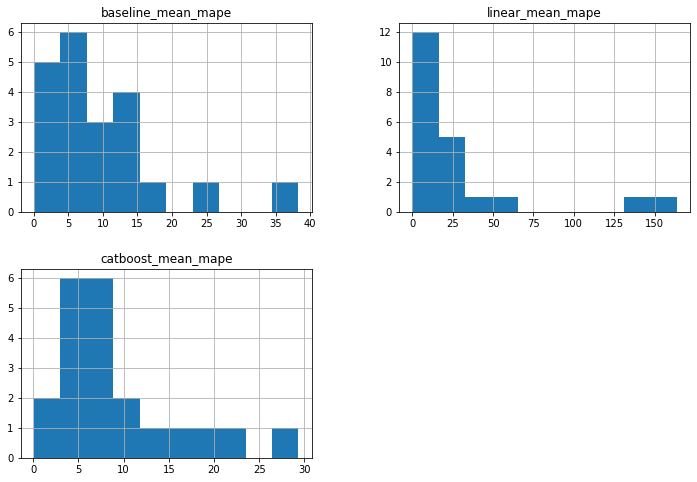

In [58]:
#Распределение ошибок
top[[i for i in top.columns if 'mean_mape' in i]].hist(figsize=(12,8))
None

Мы побили бейзлайн. Так же мы видим что большая ошибка там где было мало семплов для предсказания.

# Задачи на хакатон

## Реализовать нормальную валидацию модели бустинга. Там где достаточно много семплов можно сделать кросс-валидацию. Еще есть идея при обучении валидироваться на других наиболее похожих названиях товаров.

## Для тех товаров по которым мало историчеких данных придумать иной способ предсказания. (например предсказание предыдущей покупки + корректировка на инфляцию или линейная модель) 

##  Дополнительно обогатить данные стоимостью различных материалов (золота, металаа итд) на бирже в преиоды времени. Посмотреть корреляцию и влияние стоимостей на цену различных товаров.

## Реализовать наглядный пример использования инструмента по предсказанию цен на товары
